In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from PIL import Image
from scipy.io import loadmat
import sys

sys.path.append('../..')

from utility_codes import cmap_gallery

In [4]:
# Load MAT file generated by our MATLAB codes
#model_fio = '/Users/mary/Codes/_INPUT_/MODL_DETOX-P2.solx.mat'
model_fio = '/Users/mary/Google Drive/RR_project/Writing/Manuscript_IOcluster/Maria_P_bodywave/MODL_solx.07.dlnVp.ISC_Pdiff_RRall.mat'
mModel = loadmat(model_fio)['MODL']

In [5]:
# mModel contains all required info
# mDepths: Depths
# mDVP:    velocity file
mDepths = mModel['depths'][0][0][:, 0]
mDVP = mModel['DVP'][0][0]
mLons = mModel['lonu'][0][0][:, 0]
mLats = mModel['latu'][0][0][:, 0]

print(np.shape(mDVP))

(359, 719, 20)


In [6]:
# Min/Max depth indices for CONTOUR
depIndexMin = 16
depIndexMax = 19
print("Min Depth: %s" % mDepths[depIndexMin])
print("Max Depth: %s" % mDepths[depIndexMax])

Min Depth: 2550
Max Depth: 2885


<Figure size 2048x1024 with 0 Axes>

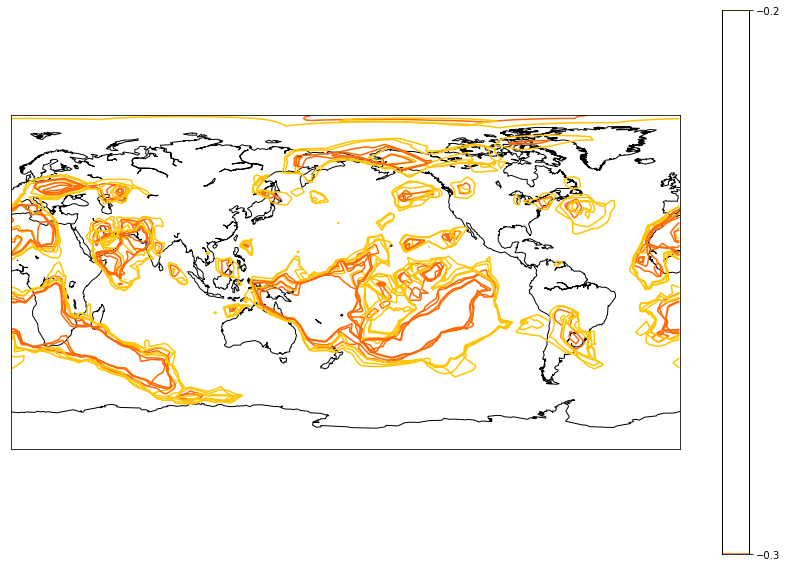

In [7]:
######## CONTOUR
plt.figure(figsize=(15, 10))

m = Basemap(projection='cyl',
            llcrnrlat=-90,urcrnrlat=90,
            llcrnrlon=0,urcrnrlon=360,
            resolution='c')

xdeg, ydeg = np.meshgrid(mLons, mLats)
x, y = m(xdeg, ydeg)
m.drawcoastlines()
# m.drawparallels(np.arange(-60., 61., 30.))
# m.drawmeridians(np.arange(-180., 181., 30.))

for i in range(depIndexMin, depIndexMax+1):
    m.contour(x, y, mDVP[:, :, i], [-0.3, -0.2], cmap='jet_r', vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.show()

In [8]:
# STEP 1 to create a customized input file for resolution test
plt.figure(figsize=(2048, 1024), dpi=1)

# XXX CHANGE THE CONDITION at XXX
depMin = 2550
depMax = 2900
depStep = 150
fileName = 'test_v02.png'

m = Basemap(projection='cyl',
            llcrnrlat=-90,urcrnrlat=90,
            llcrnrlon=0,urcrnrlon=360,
            resolution='c')
xdeg, ydeg = np.meshgrid(mLons, mLats)
x, y = m(xdeg, ydeg)

# Colorbars:
# RdBu, seismic_r, RdYlBu, coolwarm_r, BrBG, custom-001, custom-002, VM-001, VM-002
# arctic, ETOPO1, GMT_haxby, GMT_panoply, meyers, muted-d-09,
# cpt_seismic, bilbao, lajolla, oslo
numColors = 11
cmap = cmap_gallery('seismic_r', numColors)

#reqDepRange = range(depMin, depMax+depStep, depStep)
# reqDepRange = [2550, 2700, 2850, 2885]
reqDepRange = [2850, 2885]

depCounter = 0
for dep2plot in reqDepRange:
    depIndex = np.where(mDepths == dep2plot)[0][0]
    if depCounter == 0:
        mDVPdepIndex = mDVP[:, :, depIndex].copy()
        # XXX
        mDVPdepIndex[mDVPdepIndex >= -0.1] = 0
    else:
        mDVPdepIndex_tmp = mDVP[:, :, depIndex].copy()
        # XXX
        mDVPdepIndex_tmp[mDVPdepIndex_tmp >= -0.1] = 0
        mDVPdepIndex += mDVPdepIndex_tmp
    depCounter += 1

# Mask all non-zero values to 1
mDVPdepIndex[np.abs(mDVPdepIndex) > 0] = -1
m.contourf(x, y, mDVPdepIndex, cmap=cmap, vmin=-1, vmax=1)

#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.savefig(fileName, bbox_inches = 'tight')
#plt.show()

In [9]:
mDepths, dep2plot, reqDepRange

(array([ 150,  300,  450,  600,  750,  900, 1050, 1200, 1350, 1500, 1650,
        1800, 1950, 2100, 2250, 2400, 2550, 2700, 2850, 2885], dtype=uint16),
 2885,
 [2850, 2885])

In [10]:
np.shape(x)[::-1]

(719, 359)

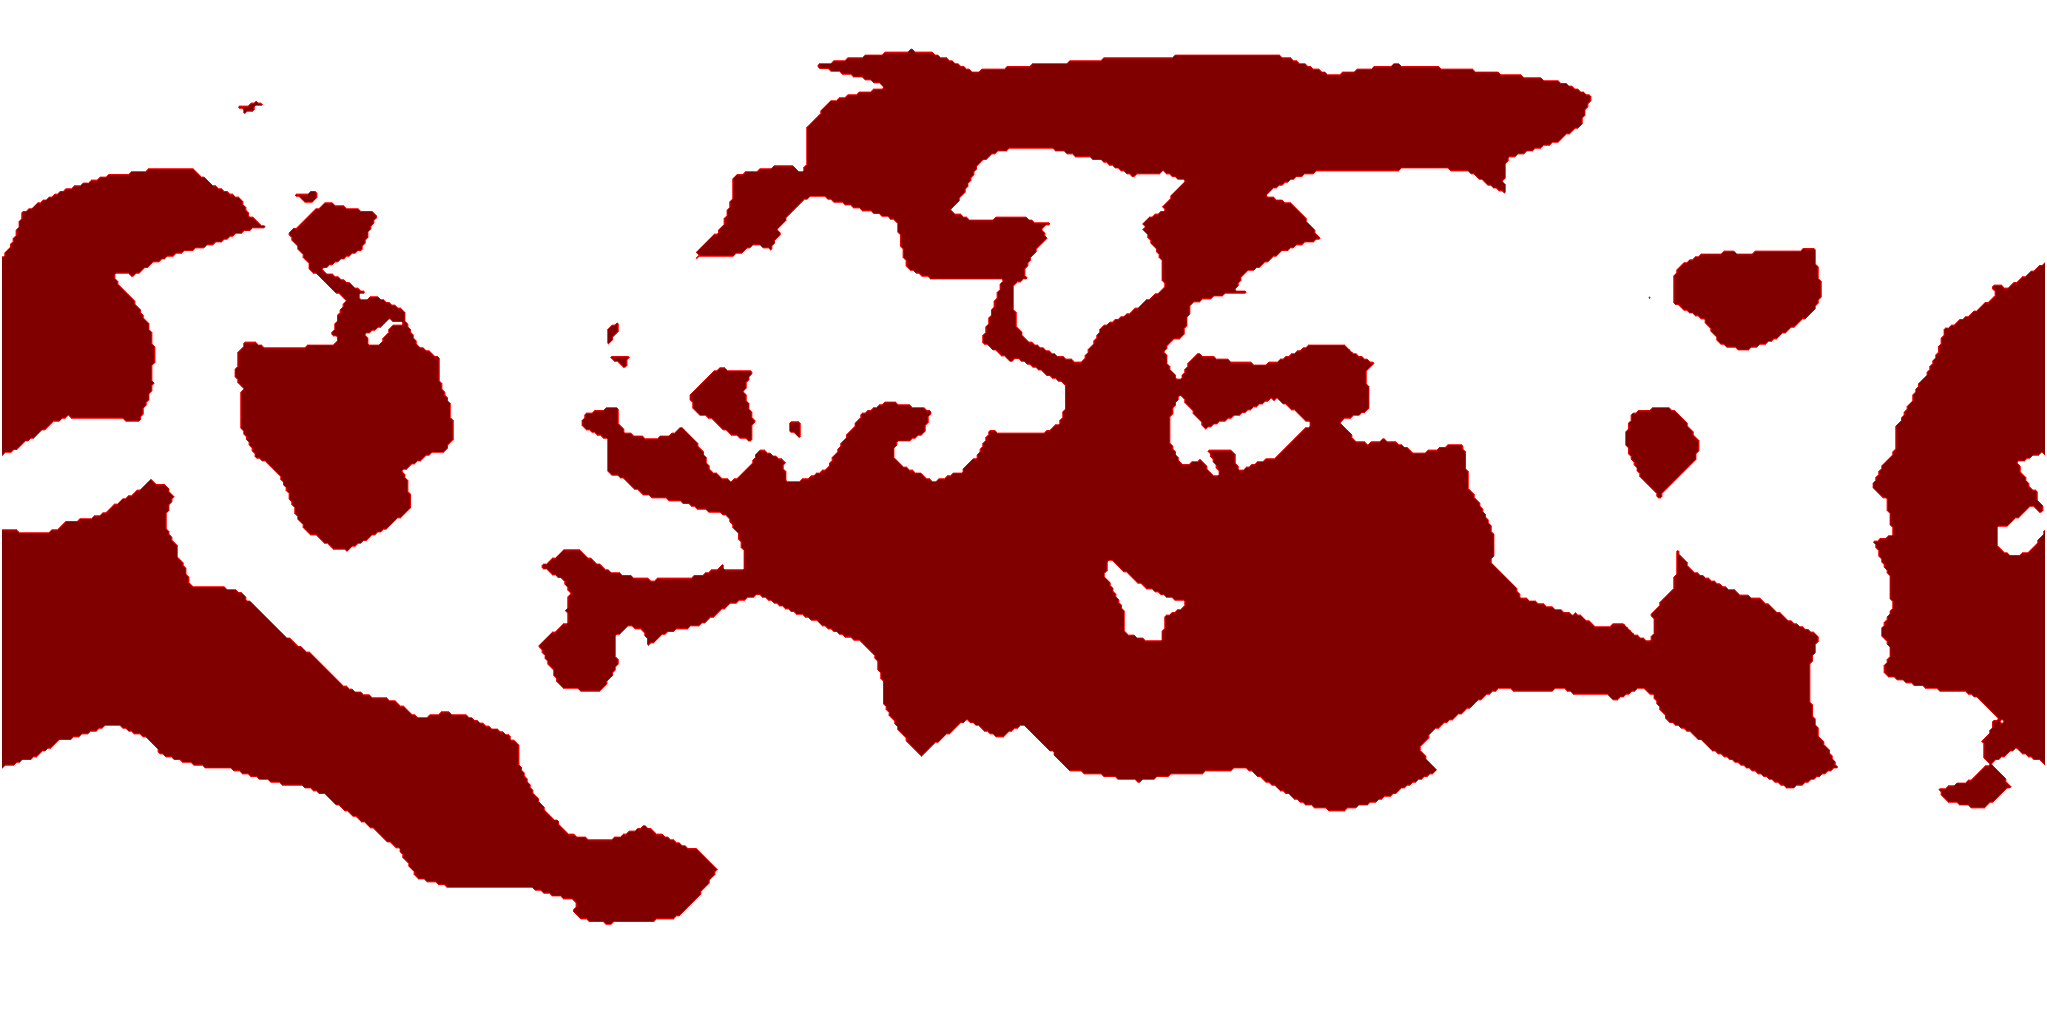

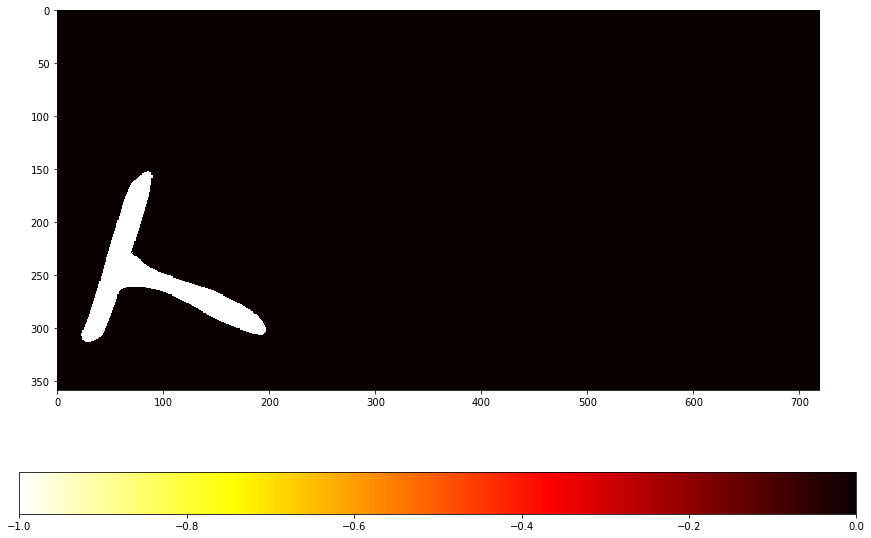

In [11]:
# Open fileName and change it as you wish
# Read fileName, resize and plot
fileName = '2600_2900_0.2.jpg'
img = Image.open(fileName)
img = img.resize(np.shape(x)[::-1], Image.ANTIALIAS) # resizes image in-place
# Gray scale
imgGray = img.convert('L')
imgGrayArr = np.asarray(imgGray)
# Black and White
imgBW = (imgGrayArr > imgGrayArr.mean())*255
# Reverse the color
imgBW[imgBW > 1] = 1
imgBW = (imgBW-1)*1

plt.figure(figsize=(15, 10))
imgplot = plt.imshow(imgBW, cmap='hot_r')
plt.colorbar(orientation='horizontal')
plt.show()

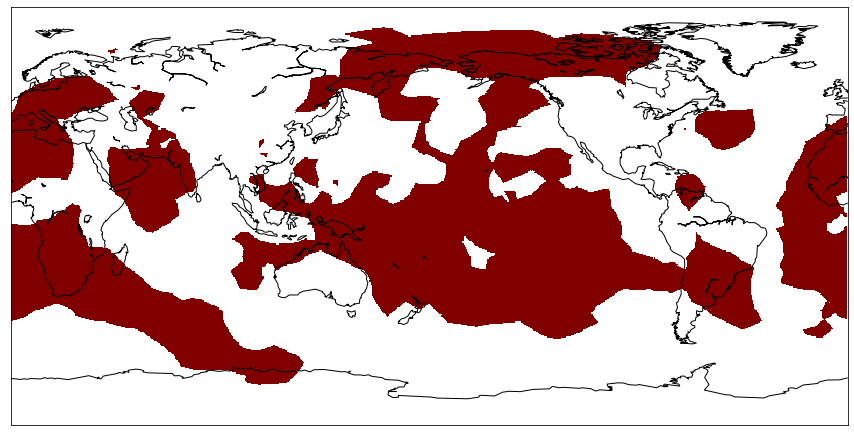

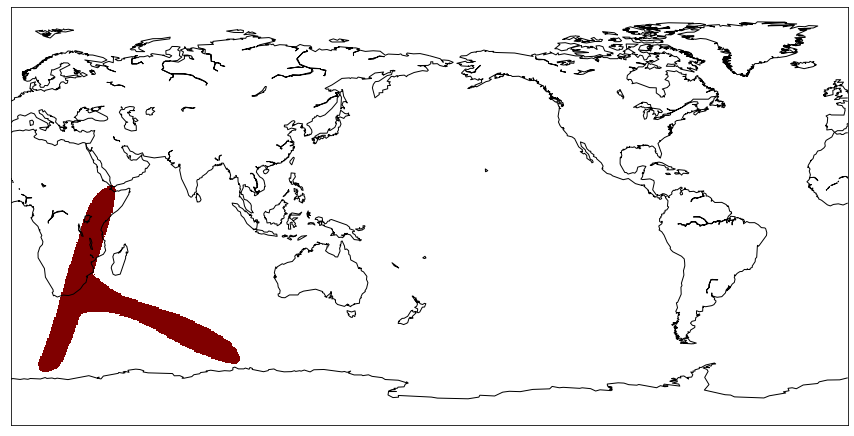

In [12]:
# Compare ORIGINAL with RESAMPLES/CHANGED version
plt.figure(figsize=(15, 10))
m = Basemap(projection='cyl',
            llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360,
            resolution='c')
m.pcolormesh(x, y, mDVPdepIndex, cmap=cmap, vmin=-1, vmax=1)
m.drawcoastlines()
plt.show()

plt.figure(figsize=(15, 10))
m = Basemap(projection='cyl',
            llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360,
            resolution='c')
m.pcolormesh(x, y, imgBW, cmap=cmap, vmin=-1, vmax=1)
m.drawcoastlines()
plt.show()

In [13]:
outputTXT = '2600_2900_m3_2.txt'
radius_list = [2900, 2800, 2700, 2600]
amplitude = -3

counter = 0
for radius in radius_list:
    
    tarRadius = 6371 - radius
    #print(radius, tarRadius)
    NonZeroArr_0 = np.vstack([np.ones(len(xdeg[np.abs(imgBW) > 0]))*tarRadius,
                            xdeg[np.abs(imgBW) > 0].T, 
                            ydeg[np.abs(imgBW) > 0].T, 
                            np.ones(len(xdeg[np.abs(imgBW) > 0]))*amplitude]).T
    
    #print(NonZeroArr_0[0])
    if counter==0:
        NonZeroArr = NonZeroArr_0
    else:
        NonZeroArr = np.vstack([NonZeroArr, NonZeroArr_0])
    print(NonZeroArr[0])
    
    counter += 1


with open(outputTXT, "w") as f:
    f.write("%s\n" % np.shape(NonZeroArr)[0])
    for line in NonZeroArr:
        f.write(f'{line[0]}, {line[1]}, {line[2]}, {line[3]}\n')
    
    f.write(f'0,0,0,0')
    
# np.savetxt(outputTXT, NonZeroArr, fmt='%.4f', delimiter=',')
f.close()

print(NonZeroArr)
print(np.shape(NonZeroArr))
print('ATTENTION: "0,0,0,0" was ADDED to the end of the file.')

[ 3.471e+03  4.300e+01  1.300e+01 -3.000e+00]
[ 3.471e+03  4.300e+01  1.300e+01 -3.000e+00]
[ 3.471e+03  4.300e+01  1.300e+01 -3.000e+00]
[ 3.471e+03  4.300e+01  1.300e+01 -3.000e+00]
[[ 3.471e+03  4.300e+01  1.300e+01 -3.000e+00]
 [ 3.471e+03  4.350e+01  1.300e+01 -3.000e+00]
 [ 3.471e+03  4.150e+01  1.250e+01 -3.000e+00]
 ...
 [ 3.771e+03  1.500e+01 -6.700e+01 -3.000e+00]
 [ 3.771e+03  1.550e+01 -6.700e+01 -3.000e+00]
 [ 3.771e+03  1.600e+01 -6.700e+01 -3.000e+00]]
(24848, 4)
ATTENTION: "0,0,0,0" was ADDED to the end of the file.


In [14]:
np.shape(NonZeroArr)[0]


24848

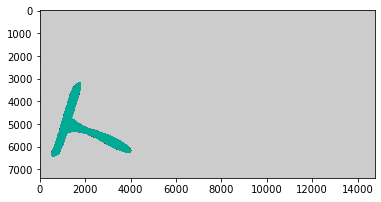

In [15]:
# OTHERS
readFile = mpimg.imread(fileName)
readFileOneChannel = readFile[:, :, 0]
plt.imshow(readFile[:, :, 0], cmap='nipy_spectral')
plt.show()

In [53]:
print(fileName)

2600_2900_0.1.jpg
